# Augustine Mass Flows vs Tilt

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pickle
import pandas as pd
import rasterio
import pyproj
import fiona
import numpy as np

matplotlib.rc('pdf', fonttype=42)

plt.style.use("/home/mchristo/proj/libmsc/style/msc.mplstyle")

## Load measured tilts and modeled tilts from inversion

In [3]:
with open("./augustineInversion/event_tilts.pkl", mode="rb") as fd:
    dfmeas = pickle.load(fd)

## Load station locations, contours, hillshade map, mass flows

In [4]:
# url to get station locations
# Built here:
# https://service.iris.edu/fdsnws/station/docs/1/builder/
url_aug = "https://service.iris.edu/fdsnws/station/1/query?net=AV&sta=AU11,AU12,AU13,AU14&cha=HHE&starttime=2005-11-01&endtime=2006-05-01&level=station&format=text&includecomments=true&nodata=404"
df_aug = pd.read_csv(url_aug, sep="|")
xform = pyproj.Transformer.from_crs("4326", "3338")
df_aug["x"], df_aug["y"] = xform.transform(df_aug[" Latitude "], df_aug[" Longitude "])

df_aug["station"] = df_aug[" Station "]
dfmeas = pd.merge(dfmeas, df_aug[["x", "y", "station"]], on="station")

In [5]:
contours = []
with fiona.open("./data/topo/augustine_ifsar_contour.gpkg") as fd:
    for line in fd:
        contours.append(list(zip(*line['geometry']['coordinates'])))

In [6]:
with rasterio.open("./data/topo/augustine_ifsar_hillshade.tif", "r") as src:
    left, bottom, right, top = src.bounds
    hillshade = src.read(1)

with rasterio.open("./data/topo/augustine_ifsar.tif", "r") as src:
    hgt_aug = src.read(1)

In [8]:
flows = []
flowevents = []
minev = []
maxev = []
with fiona.open("./data/p1769_ch08_shape/p1769_ch08_shape/MapUnits_3338.gpkg") as fd:
    for flow in fd:
        if(flow["properties"]["UnitType"] not in ["avalanche deposit", "lahar deposit", "pyroclastic flow deposit"]):
            continue
        minev.append(flow["properties"]["EventMin"])
        maxev.append(flow["properties"]["EventMax"])
        flowevents.append(flow["properties"]["EventNo"])
        flows.append(flow["geometry"]["coordinates"][0][0])

## Make plot

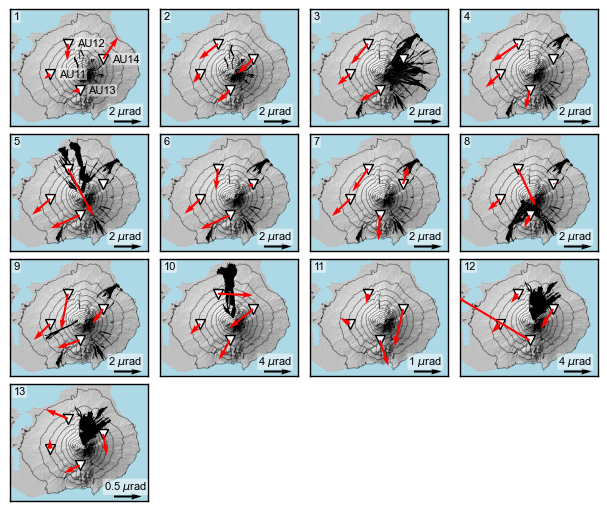

In [9]:
fig, axs = plt.subplots(4, 4, figsize=(6, 5), constrained_layout=True)

axs = axs.flatten()

events = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
subevents = [2, 3, 4, 6, 9, 13]

hillshade = hillshade.astype(np.float32)
hillshade[hgt_aug == 0] = np.nan

for i, event in enumerate(events):
    axs[i].grid(False)

    axs[i].set_facecolor("lightblue")

    # Hillshade
    axs[i].imshow(
        hillshade,
        cmap="Greys_r",
        extent=[left, right, bottom, top],
        vmin=50,
        vmax=255,
        zorder=0
    )
    axs[i].set(xlim = (left+12e3, right-5e3), ylim = (bottom+8e3, top-10.5e3), xticks=[], yticks=[])
    axs[i].set_aspect("equal")

    # Contours
    for contour in contours:
        axs[i].plot(contour[0], contour[1], 'k-', alpha=0.5, linewidth=0.5, zorder=2)

    # Mass flow
    for j, flow in enumerate(flows):
        if(flowevents[j] == event):
            bx, by, bz = list(zip(*flow))
            axs[i].fill(bx, by, zorder=1)
        if(minev[j] is not None and minev[j] <= event and maxev[j] >= event):
            bx, by, bz = list(zip(*flow))
            axs[i].fill(bx, by, zorder=1)            
    
    # Stations
    axs[i].scatter(
        df_aug["x"],
        df_aug["y"],
        marker="v",
        s=50,
        edgecolor="k",
        facecolor="w",
        zorder=3
    )

    # Station labels for first panel
    if(i == 0):
        for j, row in df_aug.iterrows():
            axs[i].text(row["x"]+2e3, row["y"], row[" Station "].strip(),
                    horizontalalignment="center",
                    verticalalignment="center",
                    fontsize=8,
                    zorder=4,
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
            )
    
    # Measured tilt
    dfmeas_sub = dfmeas[dfmeas["event"] == event]

    scale = 1e-5
    arrow = 2e-6
    alabel = "2"

    if(event in [10, 12]):
        scale *= 2
        arrow *= 2
        alabel = "4"
    
    if(event in [11]):
        scale /= 2
        arrow /= 2
        alabel = "1"
        
    if(event in [13]):
        scale /= 4
        arrow /= 4
        alabel = "0.5"
        
    # Add scale arrow
    axs[i].quiver([35e3], [1036.5e3], [arrow], [0], scale=scale, color="k", width=0.015)

    # Add label
    axs[i].annotate(
        alabel + " $\\mu$rad",
        (36e3,1037.1e3),
        fontsize=8,
        horizontalalignment="center",
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
    )

    axs[i].quiver(
        dfmeas_sub["x"], 
        dfmeas_sub["y"], 
        dfmeas_sub["etilt"], 
        dfmeas_sub["ntilt"], 
        scale=scale, 
        label="Measured", 
        color="r",
        width=0.015,
        zorder=4
    )
    
    # Add label
    axs[i].annotate(
        event,
        (.025,.91),
        xycoords="axes fraction",
        fontsize=8,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
    )

fig.delaxes(axs[13])
fig.delaxes(axs[14])
fig.delaxes(axs[15])


fig.savefig("./figs/augustine_flows_map.pdf", bbox_inches="tight")

#fig.savefig("./figs/png/augustine_flows_map.png", dpi=300, bbox_inches="tight")